In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')

This notebook is a guide for fetching data with the library of the project "". :)

Météo-France, CNRS, CNRM, Centre d’Etudes de la Neige \
Léo Catteau, Spring 2025

### Contents:
* [The Dataset ](#first-bullet)
* [Sample masking](#second-bullet)
* [Sequence masking](#third-bullet)
* [Window-horizon masking](#third-bullet)

There are up to now three types of training data, obtained through the data provider, with different masking procedures and different information available in the batches of dataloaders. 

### The Dataset <a class="anchor" id="first-bullet"></a>

In [2]:
from utils.functions import region_to_number

In [3]:
dataset = xr.load_dataset('../../datasets/bdclim_safran_2023-2024.nc').transpose()
dataset = dataset.assign_coords(station_count=("num_poste", np.arange(len(dataset.num_poste))))
display(dataset)

random_station = np.random.randint(0, len(dataset.num_poste))

<xarray.Dataset> Size: 162MB
Dimensions:              (time: 8761, num_poste: 2303)
Coordinates:
  * time                 (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01
  * num_poste            (num_poste) int64 18kB 1014002 1027003 ... 205026002
    Station_Name         (num_poste) <U30 276kB 'ARBENT' 'BALAN_AERO' ... 'FAHY'
    ZS                   (num_poste) int64 18kB 534 196 350 420 ... 485 411 596
    lat                  (num_poste) float64 18kB 46.28 45.83 ... 46.25 47.42
    lon                  (num_poste) float64 18kB 5.669 5.107 ... 6.128 6.941
    region               (num_poste) <U14 129kB 'Alpes' 'Alpes' ... 'Jura'
    reseau_poste_actuel  (num_poste) <U2 18kB '12' '29' '81' ... '74' '74' '74'
    lambx                (num_poste) float64 18kB 8.567e+03 ... 9.472e+03
    lamby                (num_poste) float64 18kB 2.147e+04 ... 2.28e+04
    station_count        (num_poste) int64 18kB 0 1 2 3 ... 2299 2300 2301 2302
Data variables:
    t                    (num_poste, time) float64 161MB 12.3 12.0 ... 4.2 4.2

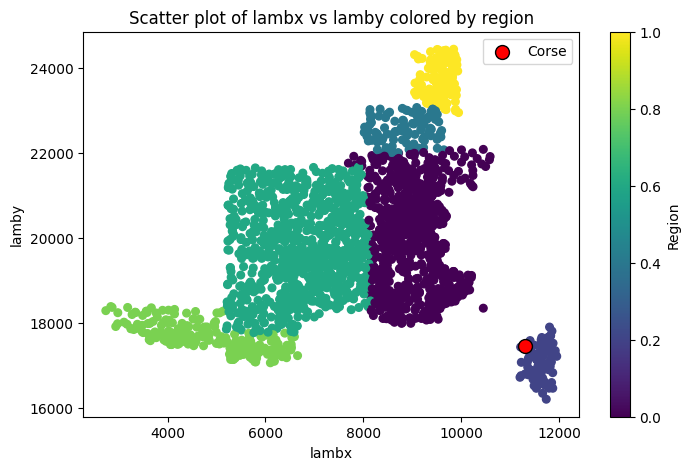

In [4]:
predictors = dataset.reset_coords().drop_vars(['t','Station_Name','reseau_poste_actuel']).isel(time=0).to_dataframe().drop(columns='time')
predictors = predictors[['region', 'lambx', 'lamby']]

plt.figure(figsize=(8, 5))
plt.scatter(predictors['lambx'], predictors['lamby'], c=region_to_number(predictors['region']), cmap='viridis', s=30)
plt.scatter(predictors.iloc[random_station]['lambx'], predictors.iloc[random_station]['lamby'], label=predictors["region"].iloc[random_station], color='red', s=100, edgecolor='black')
plt.legend()
plt.title('Scatter plot of lambx vs lamby colored by region')
plt.xlabel('lambx')
plt.ylabel('lamby')
plt.colorbar(label='Region')
plt.show()

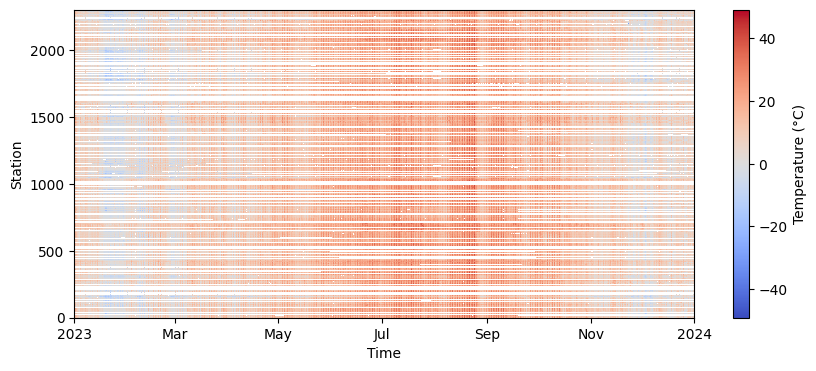

In [5]:
plt.figure(figsize=(10, 4))
dataset['t'].plot(x='time', y='station_count', cbar_kwargs={'label': "Temperature (°C)"}, cmap='coolwarm')
plt.xlabel("Time")
plt.ylabel("Station")
plt.show()

Text(0.5, 1.0, 'station 662')

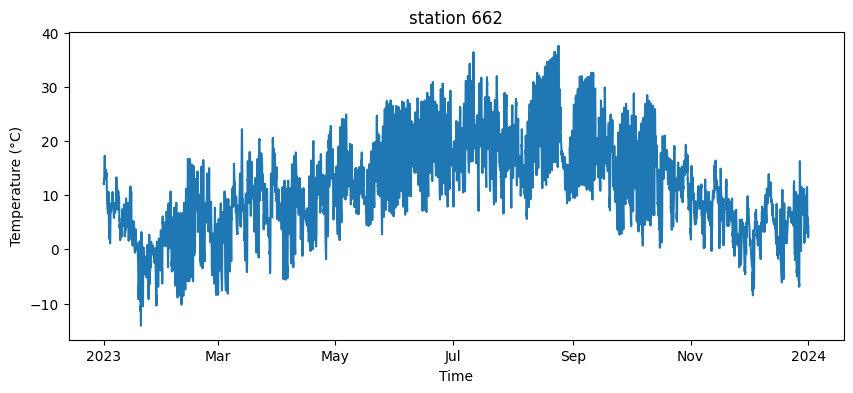

In [6]:
plt.figure(figsize=(10, 4))
dataset['t'].sel(num_poste=random_station, method='nearest').plot(x='time')
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("station " + str(random_station))

### Sample masking <a class="anchor" id="second-bullet"></a>

In [7]:
from data_provider.data_provider import DataProvider
from types import SimpleNamespace

/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [8]:
args = SimpleNamespace()
args.data = 'bdclim'
args.dataset = 'SampleMaskDataset'
args.root_path = '../../datasets/'
args.data_path = 'bdclim_safran_2023-2024.nc'
args.has_predictors = False
args.scaler = None
args.batch_size = 1
args.mask_proba = 0.25

data_provider = DataProvider(args)

before loading dataset, path:  ../../datasets/bdclim_safran_2023-2024.nc
dataset loaded
total stations:  2303 , remaining stations:  1654 , removing stations with only NaN values.
device:  cpu


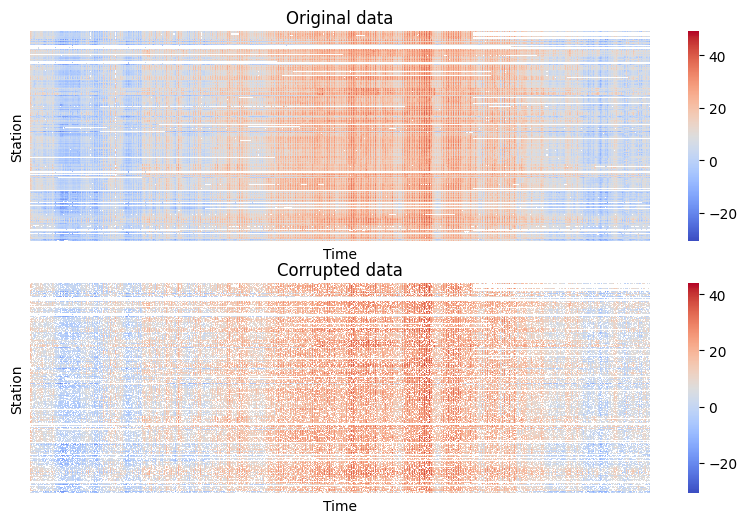

In [9]:
clean_data = data_provider.dataset.data
corrupted_data = data_provider.dataset.corrupted_data

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.heatmap(clean_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Original data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(corrupted_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Corrupted data")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
plt.show()

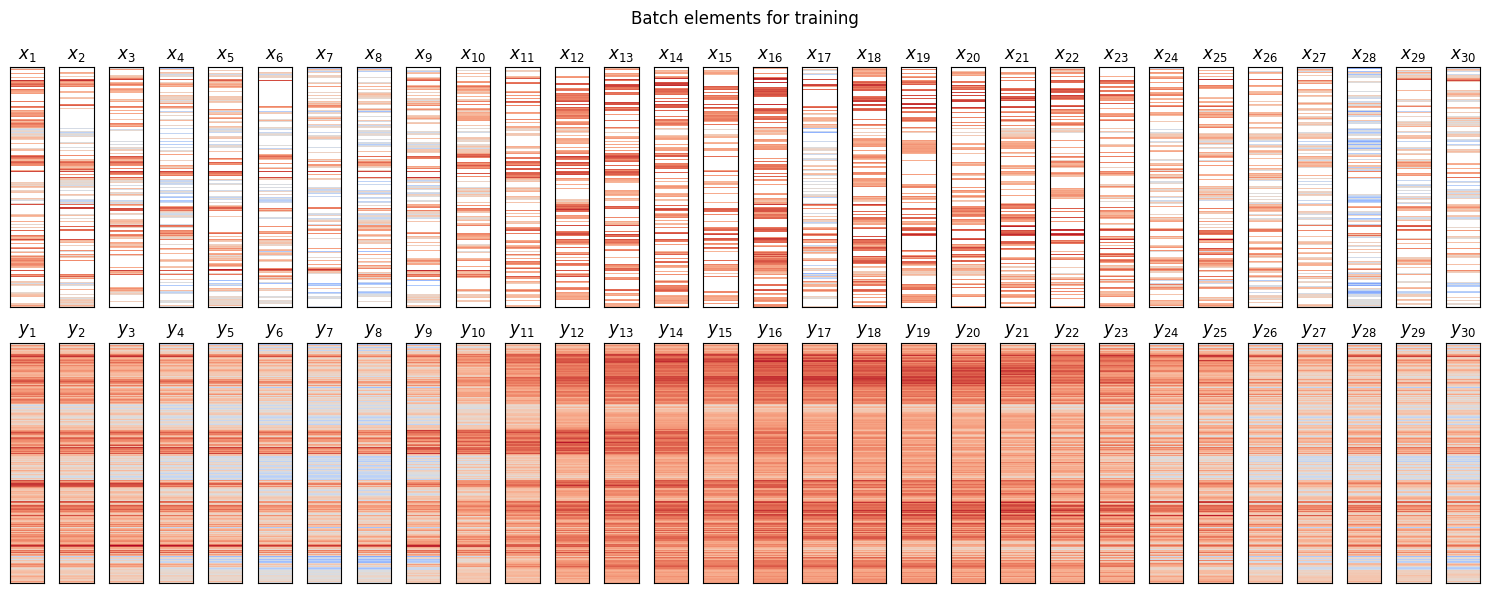

In [10]:
test_dataloader = data_provider.test_dataloader()

plt.figure(figsize=(15, 6))
iterator = 1
for batch in test_dataloader:
    if iterator > 30: 
        break
    plt.subplot(2, 30, iterator) 
    plt.imshow(batch['x'].squeeze(0,-1).numpy()[np.newaxis,:].T, cmap="coolwarm", aspect="auto")
    plt.xlim(0, .5)
    plt.ylim(0, batch['x'].shape[2]*.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"$x_{{{iterator}}}$")
    plt.subplot(2, 30, iterator + 30)
    plt.imshow(batch['y'].squeeze(0,-1).numpy()[np.newaxis,:].T, cmap="coolwarm", aspect="auto")
    plt.xlim(0, .5)
    plt.ylim(0, batch['y'].shape[2]*.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"$y_{{{iterator}}}$")
    iterator += 1
plt.suptitle('Batch elements for training')
plt.tight_layout()  
plt.show()

### Sequence masking <a class="anchor" id="third-bullet"></a>

In [11]:
from data_provider.data_provider import DataProvider
from types import SimpleNamespace

In [12]:
args = SimpleNamespace()
args.data = 'bdclim_clean'
args.dataset = 'SequenceMaskDataset'
args.root_path = '../../datasets/'
args.data_path = 'bdclim_safran_2023-2024.nc'
args.has_predictors = False
args.scaler = None
args.batch_size = 1
args.mask_length = 24*7*3
args.mask_proba = 0.5

data_provider = DataProvider(args)

device:  cpu


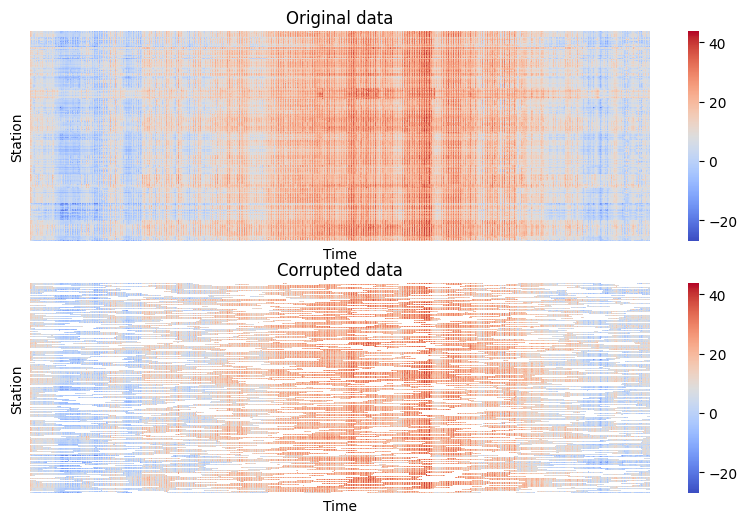

In [13]:
clean_data = data_provider.dataset.data
corrupted_data = data_provider.dataset.corrupted_data

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.heatmap(clean_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Original data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(corrupted_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Corrupted data")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
plt.show()

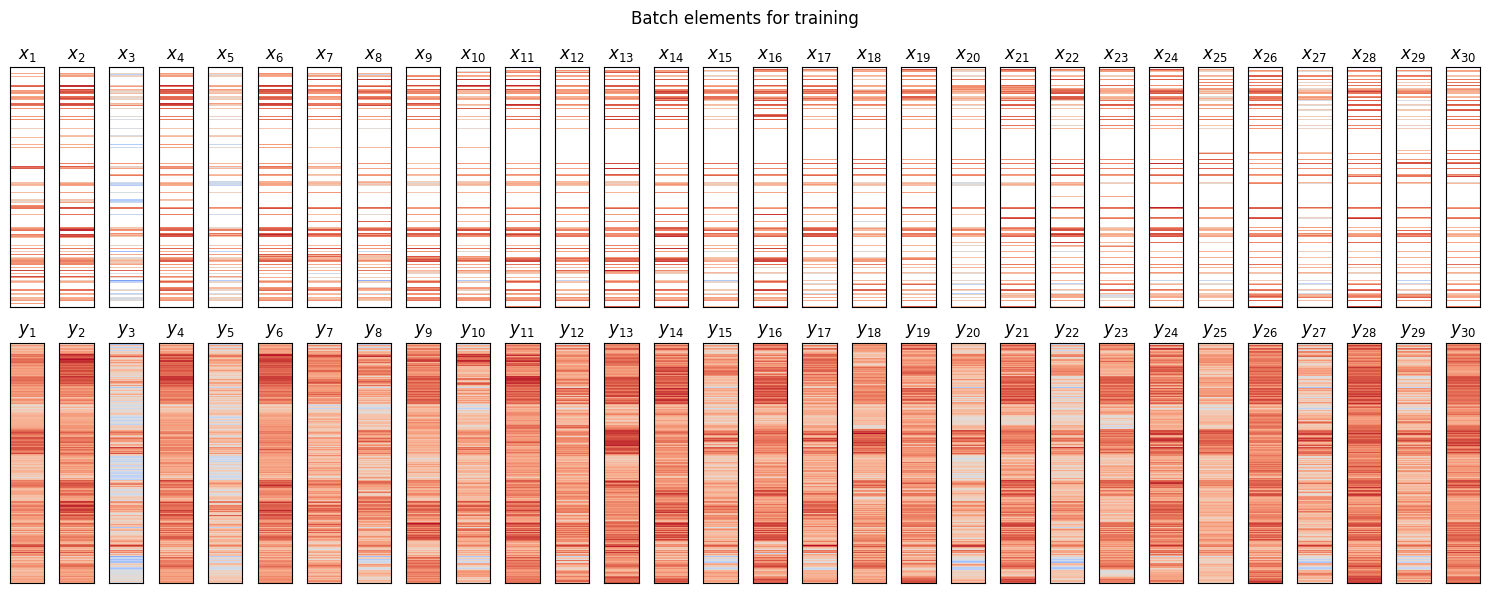

In [14]:
test_dataloader = data_provider.test_dataloader()

plt.figure(figsize=(15, 6))
iterator = 1
for batch in test_dataloader:
    if iterator > 30: 
        break
    plt.subplot(2, 30, iterator) 
    plt.imshow(batch['x'].squeeze(0,-1).numpy()[np.newaxis,:].T, cmap="coolwarm", aspect="auto")
    plt.xlim(0, .5)
    plt.ylim(0, batch['x'].shape[2]*.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"$x_{{{iterator}}}$")
    plt.subplot(2, 30, iterator + 30)
    plt.imshow(batch['y'].squeeze(0,-1).numpy()[np.newaxis,:].T, cmap="coolwarm", aspect="auto")
    plt.xlim(0, .5)
    plt.ylim(0, batch['y'].shape[2]*.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"$y_{{{iterator}}}$")
    iterator += 1
plt.suptitle('Batch elements for training')
plt.tight_layout()  
plt.show()

### Window-horizon masking <a class="anchor" id="fourth-bullet"></a>

In [15]:
from data_provider.data_provider import DataProvider
from types import SimpleNamespace

In [16]:
args = SimpleNamespace()
args.data = 'bdclim_clean'
args.dataset = 'WindowHorizonDataset'
args.root_path = '../../datasets/'
args.data_path = 'bdclim_safran_2023-2024.nc'
args.has_predictors = False
args.scaler = None
args.batch_size = 1
args.mask_length = 24*7*3
args.window = 24*7*3
args.horizon = 0
args.mask_proba = 0.25

data_provider = DataProvider(args)

device:  cpu


/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../data_provider/data_preparation.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)


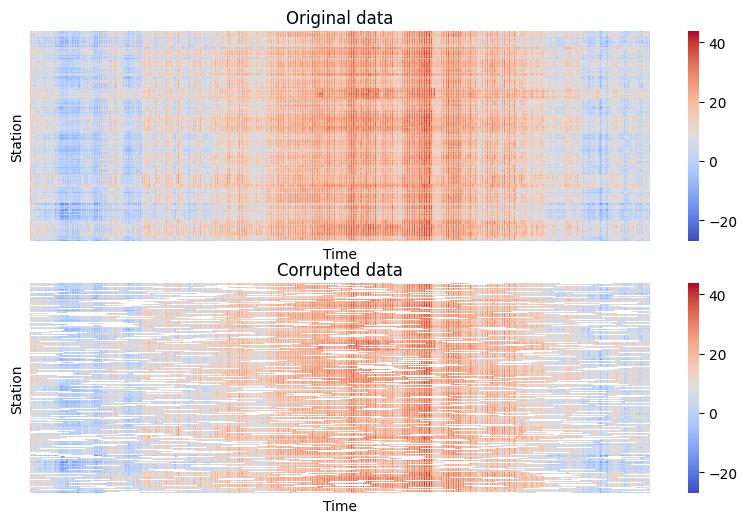

In [17]:
clean_data = data_provider.dataset.data
corrupted_data = data_provider.dataset.corrupted_data

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.heatmap(clean_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Original data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(corrupted_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Corrupted data")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
plt.show()

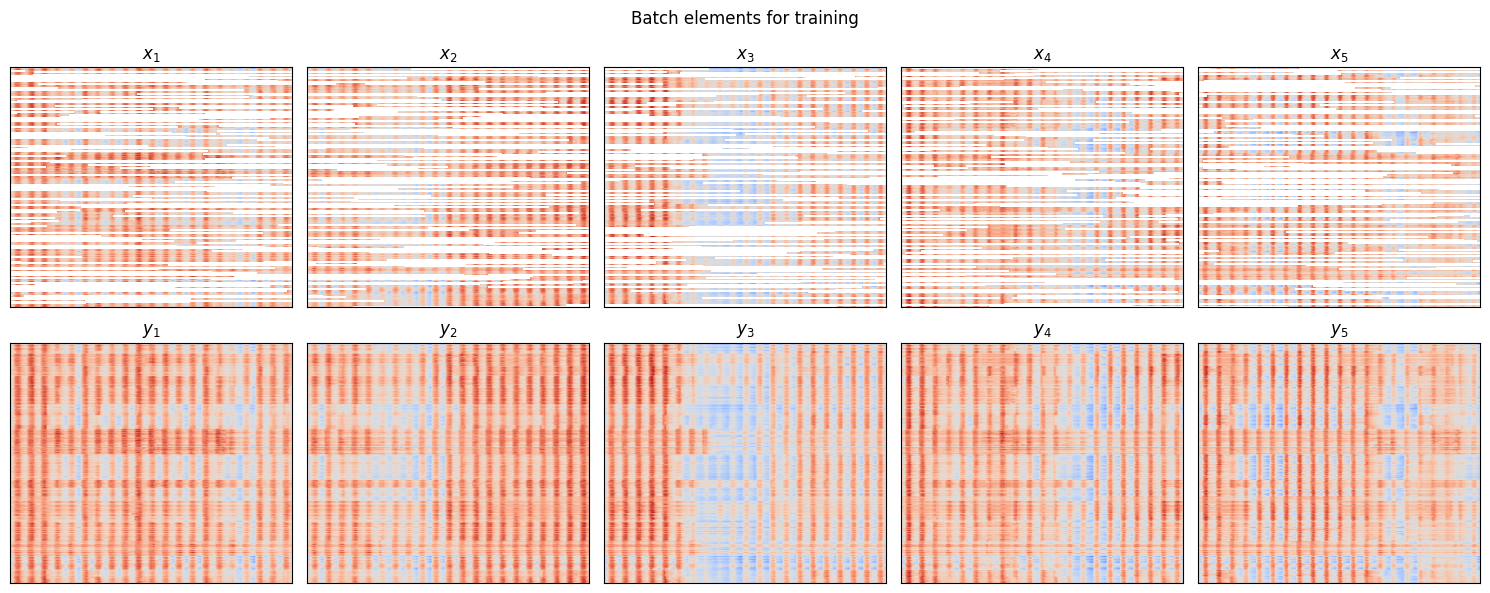

In [18]:
test_dataloader = data_provider.test_dataloader()

plt.figure(figsize=(15, 6))
iterator = 1
for batch in test_dataloader:
    if iterator > 5: 
        break
    plt.subplot(2, 5, iterator) 
    plt.imshow(batch['x'].squeeze(0,-1).numpy().T, cmap="coolwarm", aspect="auto")
    plt.xticks([])
    plt.yticks([])
    plt.ylim(0, batch['x'].shape[2]*.5)
    plt.title(f"$x_{{{iterator}}}$")
    plt.subplot(2, 5, iterator + 5)
    plt.imshow(batch['y'].squeeze(0,-1).numpy().T, cmap="coolwarm", aspect="auto")
    plt.xticks([])
    plt.yticks([])
    plt.ylim(0, batch['y'].shape[2]*.5)
    plt.title(f"$y_{{{iterator}}}$")
    iterator += 1
plt.suptitle('Batch elements for training')
plt.tight_layout()  
plt.show()